## Transfer Learning -- Use Attention on Residual network for classification (pretrained on ImageNet) 

- [List of models in pytorch](https://pytorch.org/vision/stable/models.html)
- Reads: https://arxiv.org/abs/1512.03385


### Explicit soft attention networks: Channel and spatial attentions ---> (CBAM)
- Function for channel attention
- Function for spatial attention
- Combine it as presented in CBAM -- use two 3x3 convolution (no size change)
- Make a ResNet block (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
- Call zoo model 

 ``Prepared by Sharib Ali, PhD``

In [1]:
import torch
import torchvision.models as models

In [2]:
import numpy as np
from torchvision import transforms 
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [3]:
# Load data and include prepared transform (Remember to apply same transform to both train 
# and test data)
trainset = CIFAR10("data", download=True, train=True, transform=transform)
testset = CIFAR10("data", download=True, train=False, transform=transform)

# labels of CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Step: Split between train and valset from the overall trainset
from torch.utils.data.sampler import SubsetRandomSampler
val_percentage = 0.1
num_train = len(trainset)

indices = list(range(num_train))
split = int(np.floor(val_percentage * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Now create data loaders (same as before)
# Now we need to create dataLoaders that will allow to iterate during training
batch_size = 64 # create batch-based on how much memory you have and your data size

traindataloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
valdataloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler,
            num_workers=2,)

testdataloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Number of training samples:', len(traindataloader))
print('Number of validation samples:', len(valdataloader))
print('Number of testing samples:', len(testdataloader))

Number of training samples: 704
Number of validation samples: 79
Number of testing samples: 2500


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Recall acccuracy calculation
# define accuracy
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [7]:
# Step: Define training function
from torch.utils.tensorboard import SummaryWriter
import time # to check computation time
def train(device, traindataloader, model, criterion, epochs, log_interval, tensorboardLogFile='AlexNet_Retrain'):
    losses_df = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
    print('running on...', device)
    model.to(device)
    model.train() #retrain the entire network
    writer = SummaryWriter()
    
    for epoch in range(epochs):
        start_time = time.time()
        train_loss, valid_loss, train_top1,val_top1  = [], [], [], []
        for batch_idx, (data, label) in enumerate(traindataloader):
            # initialise all your gradients to zero
            optimiser.zero_grad()
            out = model(data.to(device))
            loss = criterion(out, label.to(device))
            loss.backward()
            optimiser.step()

            # append
            train_loss.append(loss.item())
            acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
            train_top1.append(acc_1[0].item())
            


            if (batch_idx % log_interval) == 0:
                print('Train Epoch is: {}, train loss is: {:.6f}, train accuracy top1% is {}'.format(epoch, np.mean(train_loss),
                                                                                               np.mean(train_top1)))

        # every epoch write the loss and accuracy (these you can see plots on tensorboard)  

        
                with torch.no_grad():
                    for i, (data, label) in enumerate(valdataloader):
                        data, label = data.to(device), label.to(device)
                        out = model(data)
                        loss = criterion(out, label.to(device))
                        # append
                        valid_loss.append(loss.item())
                        acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
                        val_top1.append(acc_1[0].item())

                print('Val Epoch is: {}, val loss is: {:.6f}, val accuracy top1% is {}'.format(epoch, np.mean(valid_loss),
                                                                                               np.mean(val_top1)))
        writer.add_scalar(tensorboardLogFile+'/train_loss', np.mean(train_loss), epoch)
        writer.add_scalar(tensorboardLogFile+'/train_accuracy', np.mean(train_top1), epoch)
        end_time = time.time()
        print('time taken for epoch{} is {},'.format(epoch, end_time - start_time))
        
        # training loss, val loss and val accuracy
        losses_df['train_loss'].append(np.mean(train_loss))
        losses_df['train_acc'].append(np.mean(train_top1))
        losses_df['val_loss'].append(np.mean(valid_loss))
        losses_df['val_acc'].append(np.mean(val_top1))
              
    print('Finished!')
    return losses_df

In [8]:
# Step: Define test function
def evaluate(model, testdataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testdataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [9]:
def accuracyperclass(classes,model,testdataloader, device ):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testdataloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label.to(device) == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [10]:
# Plot accuracy and loss for train and val both 
import matplotlib.pyplot as plt
def plot_acc_loss(loss_acc):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = np.arange(epochs)
    plt.plot(x_range, loss_acc['train_loss'], label = 'train loss')
    plt.plot(x_range, loss_acc['val_loss'], label = 'validation loss')
    plt.title('Losses')
    plt.legend()

    plt.subplot(1,2,2)
    x_range = np.arange(epochs)
    plt.plot(x_range, loss_acc['train_acc'], label = 'train acc')
    plt.plot(x_range, loss_acc['val_acc'], label = 'val acc')
    plt.title('Accuracy')
    plt.legend()
    


In [11]:
import torch.nn as nn
import math
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# Now combine them into block
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

#     available here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [12]:
import torch.utils.model_zoo as model_zoo
__all__ = ['ResNet',  'resnet34_cbam']

model_urls = {
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
}

def resnet34_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet34'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

In [13]:
model = resnet34_cbam(pretrained=True)
model.eval()
model.fc =  nn.Linear(512,10)

# 1] create your optimiser
epochs = 20
log_interval = 500
import torch.optim as optim
learning_rate = 0.001 # Note: this is an important hyperparameter
model = model.to(device)
optimiser = optim.SGD(model.parameters(), lr = learning_rate,weight_decay=1e-6, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
# re-training of entire model
loss_acc = train(device, traindataloader, model, criterion, epochs, log_interval, tensorboardLogFile='ResNet34_Retrain_attention')

running on... cuda:0
Train Epoch is: 0, train loss is: 2.322446, train accuracy top1% is 9.375
Val Epoch is: 0, val loss is: 2.343912, val accuracy top1% is 9.849683544303797
Train Epoch is: 0, train loss is: 1.173386, train accuracy top1% is 60.416666666666664
Val Epoch is: 0, val loss is: 1.444434, val accuracy top1% is 46.25197784810127
time taken for epoch0 is 215.78997921943665,
Train Epoch is: 1, train loss is: 0.368122, train accuracy top1% is 89.0625
Val Epoch is: 1, val loss is: 0.413714, val accuracy top1% is 85.9375
Train Epoch is: 1, train loss is: 0.311034, train accuracy top1% is 89.70496506986028
Val Epoch is: 1, val loss is: 0.346903, val accuracy top1% is 88.16257911392405
time taken for epoch1 is 212.48934936523438,
Train Epoch is: 2, train loss is: 0.193293, train accuracy top1% is 93.75
Val Epoch is: 2, val loss is: 0.260083, val accuracy top1% is 91.0996835443038
Train Epoch is: 2, train loss is: 0.160853, train accuracy top1% is 94.79790419161677
Val Epoch is: 2, 

In [15]:
# testing 
evaluate(model, testdataloader, device)

Accuracy of the network on the test images: 81 %


### Display CBAM outputs on a) few testdata and b) new image

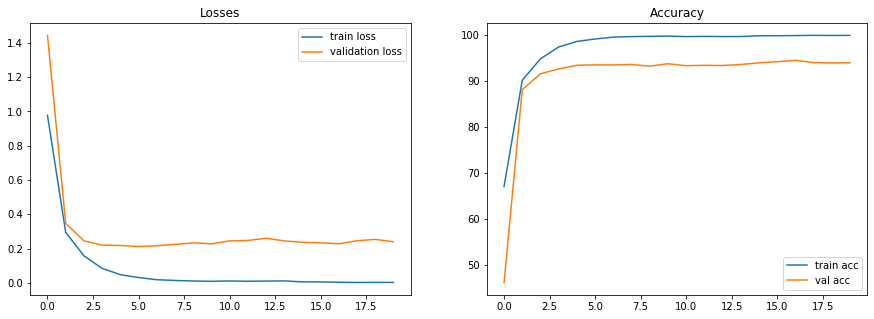

In [18]:
plot_acc_loss(loss_acc)

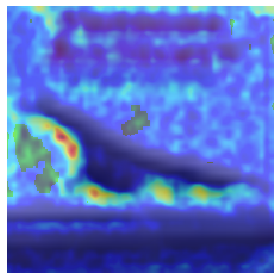

plane


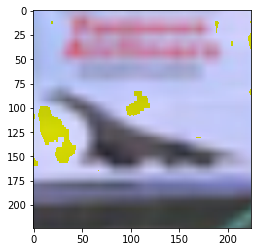

In [16]:
# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
from torchvision.io.image import read_image
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

model = model.eval()
cam_extractor = SmoothGradCAMpp(model)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)
images, labels = next(iter(testdataloader))  
idx = 3
input_tensor = images[idx]
img = inv_normalize(input_tensor)

# Preprocess your data and feed it to the model
out = model.to('cpu')(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
plt.imshow(to_pil_image(img))
print(classes[labels[idx]])

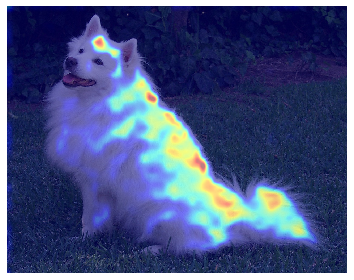

In [17]:
# Download and try on new images of dog, cat, plane etc.. 
img = read_image("/cdthome/hfk218/1280px-American_Eskimo_Dog.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
out = model.to('cpu')(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

<h3>Try different combination, have fun playing...</h3>

Comments and feedback to: [Sharib Ali](sharib.ali@eng.ox.ac.uk)